In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
%matplotlib inline
from preamble import *

In [10]:
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")
text_train, y_train = reviews_train.data, reviews_train.target
text_train = [doc.replace(b"<br />", b" ")for doc in text_train]
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
text_test = [doc.replace(b"<br />", b" ")for doc in text_test]

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [12]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
X_test = vect.transform(text_test)
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)

In [14]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5,norm=None),LogisticRegression())
param_grid = {'logisticregression__C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
X_train = vectorizer.transform(text_train)

In [16]:
import spacy
import nltk
#加载spacy的英语模型
en_nlp = spacy.load('en')
#将nltk的porter词干提取器实例化
stemmer = nltk.stem.PorterStemmer()

#定义一个函数来对比spacy中的词形还原与nltk中的词干提取
def compare_normalization(doc):
    #在spacy中对文档进行分词
    doc_spacy = en_nlp(doc)
    #打印出spacy找到的词元
    print("Lemmatization:")
    print([token.lemma_ for token in doc_spacy])
    #打印出porter词干提取器找到的词例
    print("Stemming:")
    print([stemmer.stem(token.norm_.lower()) for token in doc_spacy])

In [17]:
compare_normalization(u"Our meeting today was worse than yesterday, "
                       "I'm scared of meeting the clients tomorrow.")

Lemmatization:
['-PRON-', 'meeting', 'today', 'be', 'bad', 'than', 'yesterday', ',', '-PRON-', 'be', 'scared', 'of', 'meet', 'the', 'client', 'tomorrow', '.']
Stemming:
['our', 'meet', 'today', 'wa', 'wors', 'than', 'yesterday', ',', 'i', 'am', 'scare', 'of', 'meet', 'the', 'client', 'tomorrow', '.']


In [18]:
# 技术细节：我们希望使用由countvectorizer所使用的基于正则表达式的分词器
# 并仅使用spacy的词形还原
# 为此将en_nlp.tokenizer（spacy分词器）替换为基于正则表达式的分词
import re
# 在CountVectorizer中使用的正则表达式
regexp = re.compile('(?u)\\b\\w\\w+\\b')
# 加载spacy并保存旧的分词器
en_nlp = spacy.load('en', disable=['parser', 'ner'])
old_tokenizer = en_nlp.tokenizer
# 将分词器替换为前面的正则表达式
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(regexp.findall(string))

# 用spacy文档处理管道创建一个自定义分词器
def custom_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]

# 定义一个计数向量器
lemma_vect = CountVectorizer(tokenizer=custom_tokenizer, min_df=5)

In [19]:
# 利用带词形还原的CountVectorizer变换
X_train_lemma = lemma_vect.fit_transform(text_train)
print("X_train_lemma.shape: {}".format(X_train_lemma.shape))

# 标准CountVectorizer供参考
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train.shape: {}".format(X_train.shape))

X_train_lemma.shape: (25000, 21752)
X_train.shape: (25000, 27271)


In [ ]:
#词形还原可以看作某种正则化，他合并了某些特征，数据集很小时词形还原对性能提升最大

In [20]:
# 使用0.01的数据作为训练集构建网格搜索，使用StratifiedShuffleSplit做交叉验证
from sklearn.model_selection import StratifiedShuffleSplit

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99,
                            train_size=0.01, random_state=0)
grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv)
# 使用标准的CountVectorizer进行网格上搜索
grid.fit(X_train, y_train)
print("Best cross-validation score "
      "(standard CountVectorizer): {:.3f}".format(grid.best_score_))
# 使用词形还原进行网格搜索
grid.fit(X_train_lemma, y_train)
print("Best cross-validation score "
      "(lemmatization): {:.3f}".format(grid.best_score_))

#在本例中词形还原有较小的提高，在特定任务中努力提升最后一点性能时可以尝试

Best cross-validation score (standard CountVectorizer): 0.721
Best cross-validation score (lemmatization): 0.735


In [21]:
#LDA隐含迪利克雷分布

#删除15%的最常出现单词限定词袋为10000

vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

In [34]:
#使用batch，比online稍慢，通常给出更好的结果，增大max_iter得到更好的模型

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0)
# 在一个步骤中构建模型变换数据，同时进行
document_topics = lda.fit_transform(X)

In [35]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (10, 10000)


In [36]:
# 对每个主题(一行components_), 对特征排序 (升序).
# 用[:, ::-1]反转成倒序 
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# 从向量器中获取特征名字
feature_names = np.array(vect.get_feature_names())


# 打印前十个主题
mglearn.tools.print_topics(topics=range(10), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

In [37]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

In [38]:
#针对100个主题，选取一些有意思的，有代表性的主题

topics = np.array([7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      
--------      --------      --------      --------      --------      
thriller      worst         german        car           beautiful     
suspense      awful         hitler        gets          young         
horror        boring        nazi          guy           old           
atmosphere    horrible      midnight      around        romantic      
mystery       stupid        joe           down          between       
house         thing         germany       kill          romance       
director      terrible      years         goes          wonderful     
quite         script        history       killed        heart         
bit           nothing       new           going         feel          
de            worse         modesty       house         year          
performances  waste         cowboy        away          each          
dark          pretty        jewish        head          french        
twist 

In [39]:
# 按主题45music进行排序
music = np.argsort(document_topics100[:, 45])[::-1]
# 打印出这个主题最重要的前5个文档
for i in music[:10]:
    # 显示前两个句子
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

b'I love this movie and never get tired of watching. The music in it is great.\n'
b"I enjoyed Still Crazy more than any film I have seen in years. A successful band from the 70's decide to give it another try.\n"
b'Hollywood Hotel was the last movie musical that Busby Berkeley directed for Warner Bros. His directing style had changed or evolved to the point that this film does not contain his signature overhead shots or huge production numbers with thousands of extras.\n'
b"What happens to washed up rock-n-roll stars in the late 1990's? They launch a comeback / reunion tour. At least, that's what the members of Strange Fruit, a (fictional) 70's stadium rock group do.\n"
b'As a big-time Prince fan of the last three to four years, I really can\'t believe I\'ve only just got round to watching "Purple Rain". The brand new 2-disc anniversary Special Edition led me to buy it.\n'
b"This film is worth seeing alone for Jared Harris' outstanding portrayal of John Lennon. It doesn't matter that H

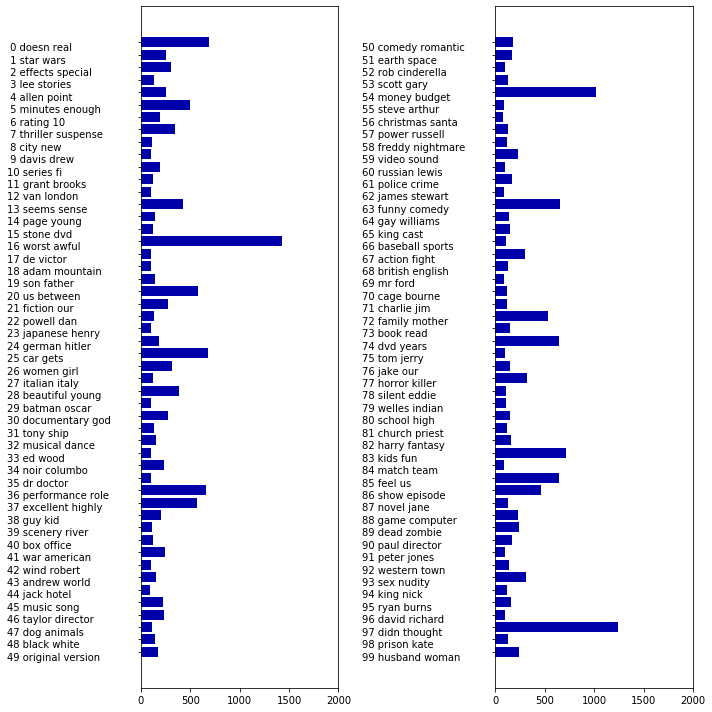

In [40]:
#给出主题权重

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# 两列条形图
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()